<a href="https://colab.research.google.com/github/diogoasilveira/Projeto-PLN/blob/main/Projeto_de_PLN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto final da disciplina de Processamento de Linguagem Natural

O projeto segue a trilha de desenvolvimento utilizando LLMs de forma não trivial, onde foi desenvolvida uma aplicação onde um usuário demonstra interesse sobre determinado tema/tópico e são retornados posts para redes sociais com informações pertinentes e úteis sobre o tema.

**Equipe:**
- Diogo Alves Silveira - 120110867

### Imports

O *Gemini* da Google será utilizado em conjunto com o framework *CrewAI* para a implementação dos agentes.

In [ ]:
!pip install --q crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29 langchain-google-genai==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 737.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 633.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.7/160.7 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from crewai import Agent, Task, Crew
from google.colab import userdata
import pathlib
import textwrap
from IPython.display import display
from IPython.display import Markdown

In [ ]:
from crewai.process import Process

In [ ]:
!mkdir data
!touch data/blog-post.md
!touch data/linkedin-post.md
!touch data/twitter-post.md
!touch data/reels-script.md

Configuração do *Gemini 1.5 Flash* como modelo de LLM a ser usado

In [ ]:
if __name__ == "__main__":

    # Load the google gemini api key
    google_api_key = userdata.get("GEMINI_API_KEY")

    # Set gemini pro as llm
    llm = ChatGoogleGenerativeAI(
        model="gemini-1.5-flash", verbose=True, temperature=0.9, google_api_key=google_api_key
    )

In [ ]:
llm.invoke("Olá, como você está?").content

'Olá! Estou bem, obrigado por perguntar. Como posso ajudar você hoje? \n'

### Agents

A aplicação possui 6 [agentes](https://docs.crewai.com/core-concepts/Agents/):
- Planejador
- Escritor
- Editor
- LinkedIn
- Twitter
- Reels

Onde cada agente assume uma tarefa diferente, de forma que é seguido o seguinte workflow: 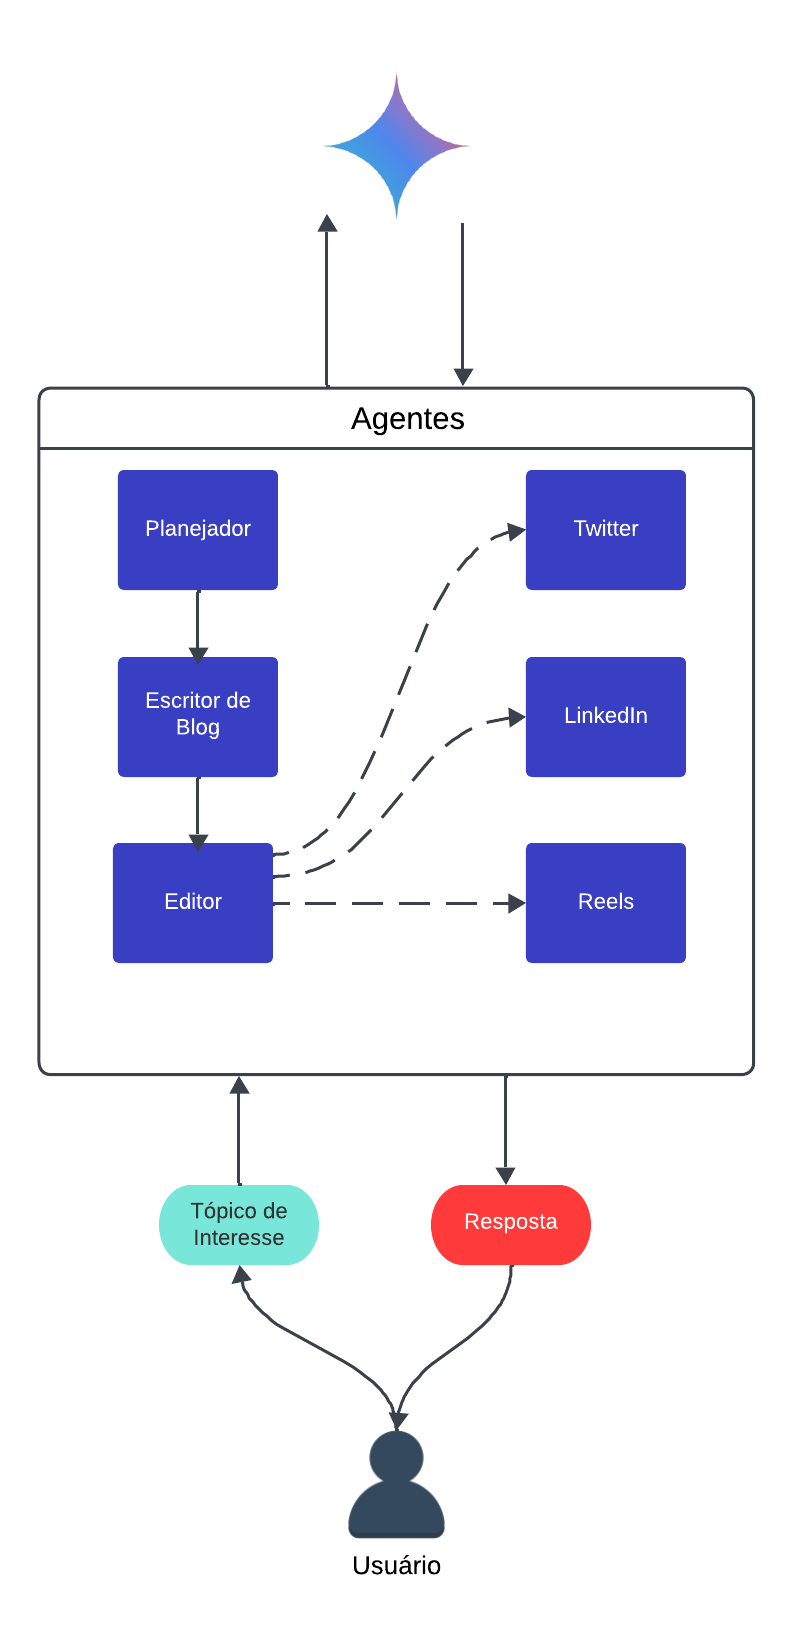

O agente *Planejador* coleta informações úteis e pertinentes sobre o tópico de interesse, passando como saída um outline com conteúdos sobre o tópico para o agente *Escritor*.

In [ ]:
planner = Agent(
    llm=llm,
    role="Planejador de Conteúdo",
    goal="Planejar conteúdo relevante e factualmente preciso no {topico}",
    backstory="Você está trabalhando no planejamento de um artigo de blog sobre o tópico: {topico}."
              "Você coleta informações que ajudam os leitores a aprender algo e a tomar decisões informadas."
              "Seu trabalho é a base para o Content Writer escrever um artigo sobre esse tópico.",
    allow_delegation=False,
    verbose=True
)

O *Escritor*, tem como função escrever um artigo para um blog com base no outline fornecido pelo *Planejador* e passará o artigo para o *Editor*.

In [ ]:
writer = Agent(
    llm=llm,
    role="Escritor de Conteúdo",
    goal="Escreva um artigo esclarecedor e factualmente preciso sobre o tópico: {topico}",
    backstory="Você está trabalhando em escrever um artigo de opinião sobre o tópico: {topico}."
              "Você baseia sua escrita no trabalho do Planejador de Conteúdo, que lhe fornece um outline e contexto relevante sobre o tópico"
              "Você segue os principais objetivos e a direção do outline, como fornecido pelo Planejador de Conteúdo."
              "Você também proverá insights objetivos e imparciais, os apoiando com informações dadas pelo Planejador de Conteúdo."
              "Você reconhece quando suas declarações são opiniões, ao invés de declarações objetivas",
    allow_delegation=False,
    verbose=True
)

O *Editor* revisa o texto recebido pelo *Escritor* para corrigir erros gramaticais e checar se o texto segue práticas de boa escrita.

In [ ]:
editor = Agent(
    llm=llm,
    role="Editor",
    goal="Edita o artigo recebido para que tenha um estilo de escrita conciso e coeso.",
    backstory="Você é um editor que recebe um post de blog do Escritor de Conteúdo."
              "Seu objeto é revisar o post recebido para garantir que ele siga as melhores práticas jornalisticas"
              "Não apresente erros de escrita e gramática"
              "E seja informativo e útil para o leitor",
    allow_delegation=False,
    verbose=True
)

A partir do artigo corrigido pelo *Editor* são criados vários posts para redes sociais diferentes feitos a partir do post para blog, onde cada post é formatado de forma que interaja bem com o público de cada rede social (LinkedIn, Twitter e Instagram).

In [ ]:
linkedin_post_agent = Agent(
    llm=llm,
    role="Criador de Post do LinkedIn",
    goal="Cria um post conciso para o LinkedIn a partir do artigo dado pelo Editor.",
    backstory="Você é um especialista em fazer posts engajantes para o linkedin que resume os tópicos complexos"
              "apresentados no post dado pelo Editor e inclui hashtags relevantes para máxima visibilidade.",
    verbose=True,
    memory=True,
    allow_delegation=False
)

In [ ]:
twitter_post_agent = Agent(
    llm=llm,
    role="Criador de Post do Twitter",
    goal="Cria um post conciso para o Twitter a partir do artigo dado pelo Editor.",
    backstory="Você é um especialista em fazer tweets que informativos que resumem os tópicos complexos"
              "apresentados no post dado pelo Editor e inclui hashtags relevantes para máxima visibilidade.",
    verbose=True,
    memory=True,
    allow_delegation=False
)

In [ ]:
instagram_reels_agent = Agent(
    llm=llm,
    role="Criador de Reels do Instagram",
    goal="Cria um roteiro conciso e cativante para um vídeo do Instagram Reels a partir do artigo dado pelo Editor.",
    backstory="Você é um especialista em escrever roteiros para vídeos do Instagram Reels informativos e intrigantes que resumem os tópicos complexos"
              "apresentados no post dado pelo Editor, inclundo hashtags relevantes para máxima visibilidade"
              "e uma pergunta intrigante que faça os telespectadores interagirem com o vídeo.",
    verbose=True,
    memory=True,
    allow_delegation=False
)

### Tasks

Especificações das [tarefas](https://docs.crewai.com/core-concepts/Tasks/) que serão realizadas por cada agente.

In [ ]:
plan = Task(
    description=(
        "1. priorizar as últimas tendências, os principais participantes,"
            "e notícias dignas de nota sobre {topico}."
        "2. identificar o público-alvo, considerando"
            "seus interesses e pontos problemáticos.\n"
        "3. Desenvolva um esboço detalhado do conteúdo, incluindo"
            "uma introdução, pontos-chave e uma chamada para ação.\n"
        "4. Inclua palavras-chave de SEO e dados ou fontes relevantes."
    ),
    expected_output="Um documento compreensível de planejamento de conteúdo"
        "com um esquema, análise de público,"
        "palavras-chave de SEO e recursos.",
    agent=planner,
)

In [ ]:
write = Task(
    description=(
        "1. Use o plano de conteúdo para criar um "
            "atraente sobre {topico}.\n"
        "2. Incorporar palavras-chave de SEO naturalmente.\n"
        "3. As seções/subtítulos são nomeados corretamente "
            "de uma maneira envolvente.\n"
        "4. Certifique-se de que a postagem esteja estruturada com uma"
            "introdução envolvente, corpo perspicaz, "
            "e uma conclusão resumida.\n"
        "5. Revise para verificar se há erros gramaticais e"
            "alinhamento com a voz da marca.\n"
    ),
    expected_output="Um post para blog bem escrito, em formato markdown, pronto para publicação"
                    "onde cada seção deve ter 2 ou 3 parágrafos.",
    agent=writer,
)

In [ ]:
edit = Task(
    description=(
        "Se certifique que o dado post para blog não apresenta"
        "erros gramaticais e é condizente com práticas de boa escrita."
    ),
    expected_output="Um post para blog bem escrito, em formato markdown, pronto para publicação"
                    "onde cada seção deve ter 2 ou 3 parágrafos.",
    agent=editor,
    output_file='./data/blog-post.md'
)

In [ ]:
linkedin = Task(
    description=(
        "Crie uma publicação no LinkedIn resumindo os principais pontos do post fornecida pelo Editor, incluindo hashtags relevantes."
    ),
    expected_output="Um post para linkedin bem escrito, em formato markdown, pronto para publicação.",
    agent=linkedin_post_agent,
    output_file='./data/linkedin-post.md'
)

In [ ]:
twitter = Task(
    description=(
        "Crie uma publicação no Twitter resumindo os principais pontos do post fornecida pelo Editor, incluindo hashtags relevantes."
    ),
    expected_output="Um tweet bem escrito, em formato markdown, pronto para publicação.",
    agent=twitter_post_agent,
    output_file='./data/twitter-post.md'
)

In [ ]:
reels = Task(
    description=(
        "Crie o roteiro para um vídeo no Instagram Reels resumindo os principais pontos do post fornecida pelo Editor, incluindo uma pergunta intrigante sobre o tópico para prender a atenção do telespectador."
    ),
    expected_output="Um roteiro bem escrito, em formato markdown, pronto para gravação.",
    agent=twitter_post_agent,
    output_file='./data/reels-script.md'
)

### Crew

[Conjunto](https://docs.crewai.com/core-concepts/Crews/) que representa o agrupamento colaborativodos agentes para a realização de suas tarefas.

In [ ]:
crew = Crew(
    agents=[planner, writer, editor, linkedin_post_agent, twitter_post_agent, instagram_reels_agent],
    tasks=[plan, write, edit, linkedin, twitter, reels],
    verbose=2,
    output_dir='./data'
)

In [ ]:
result = crew.kickoff(inputs={"topico": "Open Source"})

 [DEBUG]: == Working Agent: Planejador de Conteúdo
 [INFO]: == Starting Task: 1. priorizar as últimas tendências, os principais participantes,e notícias dignas de nota sobre Open Source.2. identificar o público-alvo, considerandoseus interesses e pontos problemáticos.
3. Desenvolva um esboço detalhado do conteúdo, incluindouma introdução, pontos-chave e uma chamada para ação.
4. Inclua palavras-chave de SEO e dados ou fontes relevantes.


> Entering new CrewAgentExecutor chain...
Thought: I now can give a great answer.

Final Answer:

## Plano de Conteúdo: Open Source

**Objetivo:** Criar um artigo de blog informativo e envolvente sobre Open Source, ajudando os leitores a entender o conceito, suas vantagens, desafios e tendências relevantes, além de inspirá-los a se envolver com a comunidade.

**Público-alvo:**

* **Desenvolvedores:** Profissionais de tecnologia que buscam ferramentas e recursos para seus projetos.
* **Empresas:** Líderes de negócios que desejam explorar os benefícios 

### Resultados

In [ ]:
from rich.console import Console
from rich.markdown import Markdown
console = Console()

#### Post para Blog/Medium

In [ ]:
with open('./data/blog-post.md') as f:
    md = Markdown(f.read())
    console.print(md)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                           Abrace o Open Source: Desvendando o Poder do Código Aberto                            ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

O Open Source, ou código aberto, revolucionou o mundo da tecnologia, permitindo que desenvolvedores e empresas     
colaborem para criar e compartilhar software de forma transparente e acessível. Mas o que exatamente é Open Source?
E como ele impacta nossas vidas?                                                                                   


                                           Open Source: Uma Visão Geral                                            

Open Source significa que o código-fonte de um software está disponível para todos visualizarem, modificarem e     
distribuírem livremente. Essa liberdade de acesso e modificação permite que uma comunidade global de               
desenvolvedores trabalhe em conjunto para melhorar o software, corrigir bugs e adicionar novas funcionalidades.    
Essa colaboração contínua contribui para a criação de software confiável, inovador e de alta qualidade.            


                                Benefícios do Open Source: Um Tesouro de Vantagens                                 

O Open Source oferece uma série de vantagens tanto para desenvolvedores quanto para empresas. Uma das mais         
importantes é a redução de custos. Ao utilizar software Open Source, empresas podem economizar com licenças caras e
reduzir os custos de desenvolvimento e manutenção. A flexibilidade também é um ponto crucial. A capacidade de      
personalizar e adaptar o software às necessidades específicas de cada projeto garante soluções personalizadas e    
eficientes.                                                                                                        

A segurança também é um fator essencial. Devido à natureza colaborativa do Open Source, o código é constantemente  
revisado e auditado por uma vasta comunidade de desenvolvedores, o que contribui para a identificação e correção   
rápida de vulnerabilidades. A comunidade vibrante que cerca o Open Source é um dos seus maiores trunfos. Essa      
comunidade oferece suporte, compartilhamento de conhecimento e uma rede de colaboração que impulsiona a inovação e 
a resolução de problemas de forma eficiente.                                                                       


                              Desafios do Open Source: Compreendendo as Complexidades                              

Apesar de suas inúmeras vantagens, o Open Source também apresenta alguns desafios. A complexidade em encontrar e   
integrar soluções Open Source adequadas pode ser um obstáculo para iniciantes. A manutenção de projetos Open Source
também exige atenção, pois a responsabilidade de atualização e suporte pode variar entre os projetos.              

A documentação completa e de alta qualidade é essencial para garantir a utilização eficaz do software. O           
gerenciamento de dependências também é um desafio, pois a atualização de um componente pode afetar outras partes do
sistema. No entanto, a comunidade Open Source está constantemente trabalhando para superar esses desafios,         
desenvolvendo ferramentas e recursos para facilitar o uso e a manutenção de projetos Open Source.                  


                             O Futuro do Open Source: Tendências que Moldam o Cenário                              

O Open Source está em constante evolução, impulsionado por tendências tecnológicas que moldam o cenário digital. A 
inteligência artificial (IA) e o machine learning (ML) são áreas em que o Open Source desempenha um papel crucial. 
Frameworks e bibliotecas Open Source permitem que desenvolvedores construam e implementem soluções de IA e ML de   
forma rápida e eficiente.                

#### Post do LinkedIn

In [ ]:
with open('./data/linkedin-post.md') as f:
    md = Markdown(f.read())
    console.print(md)

Abrace o Open Source: Desvendando o Poder do Código Aberto                             

O Open Source revolucionou a tecnologia, permitindo colaboração global para criar software acessível. Mas o que é  
Open Source e como ele nos impacta?                                                                                

Open Source: Código Livre para Todos                                                                               

Significa que o código-fonte de um software está disponível para todos visualizarem, modificarem e distribuírem.   
Essa liberdade permite que uma comunidade global de desenvolvedores trabalhe em conjunto para melhorar o software, 
corrigir bugs e adicionar novas funcionalidades. Essa colaboração contínua resulta em software confiável, inovador 
e de alta qualidade.                                                                                               

Benefícios do Open Source:                                                                                         

 • Redução de Custos: Elimina licenças caras e diminui custos de desenvolvimento e manutenção.                     
 • Flexibilidade: Permite personalização e adaptação às necessidades específicas de cada projeto.                  
 • Segurança: O código é constantemente revisado por uma vasta comunidade, garantindo identificação e correção     
   rápida de vulnerabilidades.                                                                                     
 • Comunidade Vibrante: Suporte, compartilhamento de conhecimento e uma rede de colaboração impulsionam a inovação 
   e a resolução de problemas.                                                                                     

Desafios do Open Source:                                                                                           

 • Complexidade: Encontrar e integrar soluções Open Source adequadas pode ser um desafio para iniciantes.          
 • Manutenção: A responsabilidade de atualização e suporte varia entre os projetos.                                
 • Documentação: Documentação completa e de alta qualidade é essencial para o uso eficaz do software.              
 • Gerenciamento de Dependências: Atualizar um componente pode afetar outras partes do sistema.                    

O Futuro do Open Source:                                                                                           

 • Inteligência Artificial (IA) e Machine Learning (ML): Frameworks e bibliotecas Open Source permitem a construção
   e implementação de soluções de IA e ML de forma rápida e eficiente.                                             
 • Cloud Computing: Plataformas de cloud computing, como o OpenStack, oferecem flexibilidade, escalabilidade e     
   custo-efetividade.                                                                                              
 • Blockchain e Criptomoedas: Projetos como o Hyperledger Fabric e o Ethereum promovem a transparência, segurança e
   descentralização.                                                                                               
 • Internet das Coisas (IoT): Plataformas e frameworks Open Source facilitam o desenvolvimento de dispositivos IoT,
   conectando o mundo físico ao digital de forma segura e eficiente.                                               

Exemplos de Open Source:                                                                                           

 • Linux: Sistema operacional Open Source mais popular, utilizado em servidores, dispositivos móveis e desktops.   
 • Apache Web Server: Um dos servidores web mais utilizados, responsável por hospedar milhões de sites.            
 • MySQL: Sistema de gerenciamento de banco de dados Open Source, utilizado por empresas de todos os tamanhos.     
 • WordPress: Plataforma de gerenciamento de conteúdo Open Source, utilizada para criar blogs, sites e aplicativos 
   web.                                                                  

#### Post do Twitter

In [ ]:
with open('./data/twitter-post.md') as f:
    md = Markdown(f.read())
    console.print(md)

Open Source empowers collaboration & innovation! 💻 Learn how it works, its benefits & challenges, and how you can 
contribute.  #opensource #softwarelivre #codigooberto #tecnologia #inovação #colaboração #IA #ML #cloudcomputing   
#blockchain #IoT #linux #apache #mysql #wordpress  [Link to article]

#### Roteiro para Reels

In [ ]:
with open('./data/reels-script.md') as f:
    md = Markdown(f.read())
    console.print(md)

Open Source: The Power of Collaboration 🤝                                     

[Intro music]                                                                                                      

Video: Quick shots of people coding, diverse teams collaborating, open source logos (Linux, Apache, etc.)          

Voiceover:  Ever wondered how your favorite apps and websites are built?  Many rely on open-source software!  💻   

[Transition to text overlay]                                                                                       

Text: Open Source: Code shared freely, anyone can contribute.                                                      

Voiceover: This means anyone can access, modify, and improve the software.  It fosters innovation and allows for   
rapid development.                                                                                                 

[Transition to text overlay]                                                                                       

Text: Benefits:                                                                                                    

 • Collaboration & Innovation                                                                                      
 • Faster Development                                                                                              
 • Reduced Costs                                                                                                   

Voiceover: But open source isn't without challenges.  Security and licensing can be complex.                       

[Transition to text overlay]                                                                                       

Text: Challenges:                                                                                                  

 • Security Risks                                                                                                  
 • Licensing Complexity                                                                                            
 • Lack of Support                                                                                                 

Voiceover:  So, how can YOU contribute to open source?  🤔                                                         

[Transition to video of person coding]                                                                             

Text:  Join a project, fix bugs, or write documentation!                                                           

Voiceover:   Every contribution makes a difference.  Let's build a better future, together!                        

[Outro music]                                                                                                      

Text:  Learn more: [Link to article]                                                                               

#opensource #softwarelivre #codigooberto #tecnologia #inovação #colaboração #IA #ML #cloudcomputing #blockchain    
#IoT #linux #apache #mysql #wordpress